# **UAP Machine Learning C**

# **Klasifikasi Jenis Ikan**

# **Ferdy Rizal Mahendra Putra**

# **202210370311161**

#**1. Load Datase myfish (TAHAP 1)**

#**Model Non-PreTrained (CNN)**


In [ ]:
import os
import shutil
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Mount Drive
drive.mount('/content/drive')

# Path
DRIVE_DATASET_PATH = "/content/drive/MyDrive/UAP_klasifikasi_ikan/mydataset"
LOCAL_DATASET_PATH = "/content/mydataset"
MODEL_SAVE_PATH = "/content/drive/MyDrive/UAP_klasifikasi_ikan/Model_Final"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Copy Dataset ke Local (Agar Training Cepat)
if not os.path.exists(LOCAL_DATASET_PATH):
    shutil.copytree(DRIVE_DATASET_PATH, LOCAL_DATASET_PATH)
    print("✅ Dataset copied to local")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset copied to local


# **Tahap 2**

**LOAD DATASET & AUGMENTASI**

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Load Train & Validation (label_mode='categorical' untuk mencegah error loss)
train_ds = tf.keras.utils.image_dataset_from_directory(
    LOCAL_DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    LOCAL_DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Save labels untuk Streamlit
with open(os.path.join(MODEL_SAVE_PATH, "fish_labels_final.json"), "w") as f:
    json.dump(class_names, f)

# Augmentasi untuk mencegah overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6905 files belonging to 5 classes.
Using 5524 files for training.
Found 6905 files belonging to 5 classes.
Using 1381 files for validation.


# **Tahap 3**

**Membangun Model CNN**



In [ ]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),
    data_augmentation,

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5), # Mencegah overfitting
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# **TAHAP 4**

**Training**

In [ ]:
callbacks = [
    ModelCheckpoint(os.path.join(MODEL_SAVE_PATH, "fish_classifier_final.h5"),
                    save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

print("\n🚀 Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


🚀 Starting Training...
Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7449 - loss: 1.4456

173/173 ━━━━━━━━━━━━━━━━━━━━ 116s 257ms/step - accuracy: 0.7453 - loss: 1.4425 - val_accuracy: 0.1694 - val_loss: 16.5699 - learning_rate: 1.0000e-04
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8860 - loss: 0.3905

173/173 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.8861 - loss: 0.3901 - val_accuracy: 0.5243 - val_loss: 4.8028 - learning_rate: 1.0000e-04
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9115 - loss: 0.2792

173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.9115 - loss: 0.2792 - val_accuracy: 0.9522 - val_loss: 0.2162 - learning_rate: 1.0000e-04
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9375 - loss: 0.2159

173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - accuracy: 0.9375 - loss: 0.2159 - val_accuracy: 0.9645 - val_loss: 0.0972 - learning_rate: 1.0000e-04
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.9416 - loss: 0.2001 - val_accuracy: 0.9594 - val_loss: 0.1656 - learning_rate: 1.0000e-04
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9302 - loss: 0.2850

173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.9302 - loss: 0.2847 - val_accuracy: 0.9862 - val_loss: 0.0473 - learning_rate: 1.0000e-04
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.9593 - loss: 0.1298 - val_accuracy: 0.9761 - val_loss: 0.0652 - learning_rate: 1.0000e-04
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9561 - loss: 0.1485

173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9561 - loss: 0.1484 - val_accuracy: 0.9884 - val_loss: 0.0388 - learning_rate: 1.0000e-04
Epoch 9/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.9683 - loss: 0.1065 - val_accuracy: 0.9804 - val_loss: 0.0536 - learning_rate: 1.0000e-04
Epoch 10/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9663 - loss: 0.1189 - val_accuracy: 0.9884 - val_loss: 0.0373 - learning_rate: 1.0000e-04
Epoch 11/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9594 - loss: 0.1491 - val_accuracy: 0.9783 - val_loss: 0.0857 - learning_rate: 1.0000e-04
Epoch 12/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9703 - loss: 0.1105 - val_accuracy: 0.9848 - val_loss: 0.0527 - learning_rate: 1.0000e-04
Epoch 13/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9721 - loss: 0.0965 - val_accuracy: 0.9877 - val_loss: 0.0388 - learning_rate: 1.0000e-04
Epoch 14/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/ste

173/173 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step - accuracy: 0.9811 - loss: 0.0709 - val_accuracy: 0.9913 - val_loss: 0.0234 - learning_rate: 2.0000e-05
Epoch 15/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9831 - loss: 0.0499

173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 210ms/step - accuracy: 0.9831 - loss: 0.0499 - val_accuracy: 0.9942 - val_loss: 0.0283 - learning_rate: 2.0000e-05
Epoch 16/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9888 - loss: 0.0373

173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 184ms/step - accuracy: 0.9888 - loss: 0.0373 - val_accuracy: 0.9971 - val_loss: 0.0097 - learning_rate: 2.0000e-05
Epoch 17/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.9861 - loss: 0.0395 - val_accuracy: 0.9957 - val_loss: 0.0152 - learning_rate: 2.0000e-05
Epoch 18/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9912 - loss: 0.0274

173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 228ms/step - accuracy: 0.9912 - loss: 0.0274 - val_accuracy: 0.9986 - val_loss: 0.0071 - learning_rate: 2.0000e-05
Epoch 19/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.9927 - loss: 0.0288 - val_accuracy: 0.9978 - val_loss: 0.0068 - learning_rate: 2.0000e-05
Epoch 20/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.9931 - loss: 0.0241 - val_accuracy: 0.9971 - val_loss: 0.0094 - learning_rate: 2.0000e-05
Epoch 21/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9928 - loss: 0.0274 - val_accuracy: 0.9957 - val_loss: 0.0156 - learning_rate: 2.0000e-05
Epoch 22/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.9921 - loss: 0.0239 - val_accuracy: 0.9978 - val_loss: 0.0185 - learning_rate: 2.0000e-05
Epoch 23/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9912 - loss: 0.0303 - val_accuracy: 0.9978 - val_loss: 0.0105 - learning_rate: 4.0000e-06
Epoch 24/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/s

# **TAHAP 5**

**EVALUASI & PLOTTING**

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

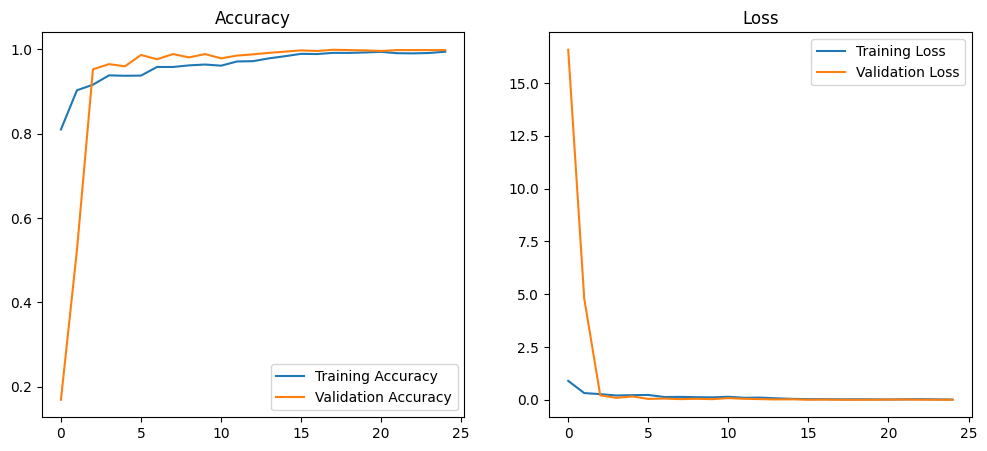

In [ ]:
plot_history(history)

# **TAHAP 6**

CONFUSION MATRIX & REPORT


📊 Classification Report:
                          precision    recall  f1-score   support

             Archer Fish       1.00      1.00      1.00       263
              Betta Fish       1.00      1.00      1.00       234
               Blue tang       1.00      1.00      1.00       306
Clown Sword Trigger Fish       0.99      1.00      0.99       276
             Yellow Tang       1.00      1.00      1.00       302

                accuracy                           1.00      1381
               macro avg       1.00      1.00      1.00      1381
            weighted avg       1.00      1.00      1.00      1381



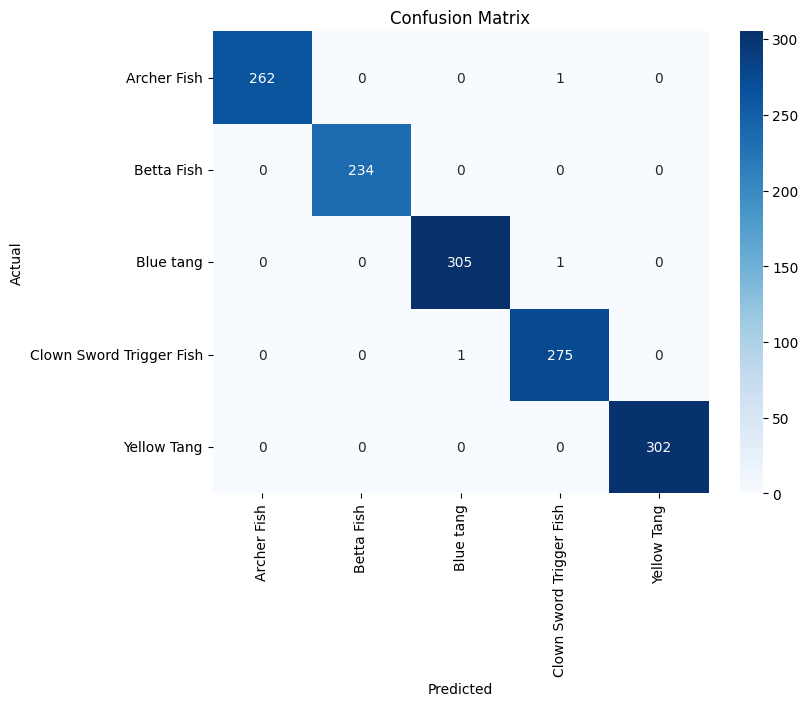

In [ ]:
y_pred_all = []
y_true_all = []

for x, y in val_ds:
    preds = model.predict(x, verbose=0)
    y_pred_all.extend(np.argmax(preds, axis=1))
    y_true_all.extend(np.argmax(y, axis=1))

print("\n📊 Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **TAHAP 7**

**PREDIKSI GAMBAR ACAK (TIAP KELAS)**

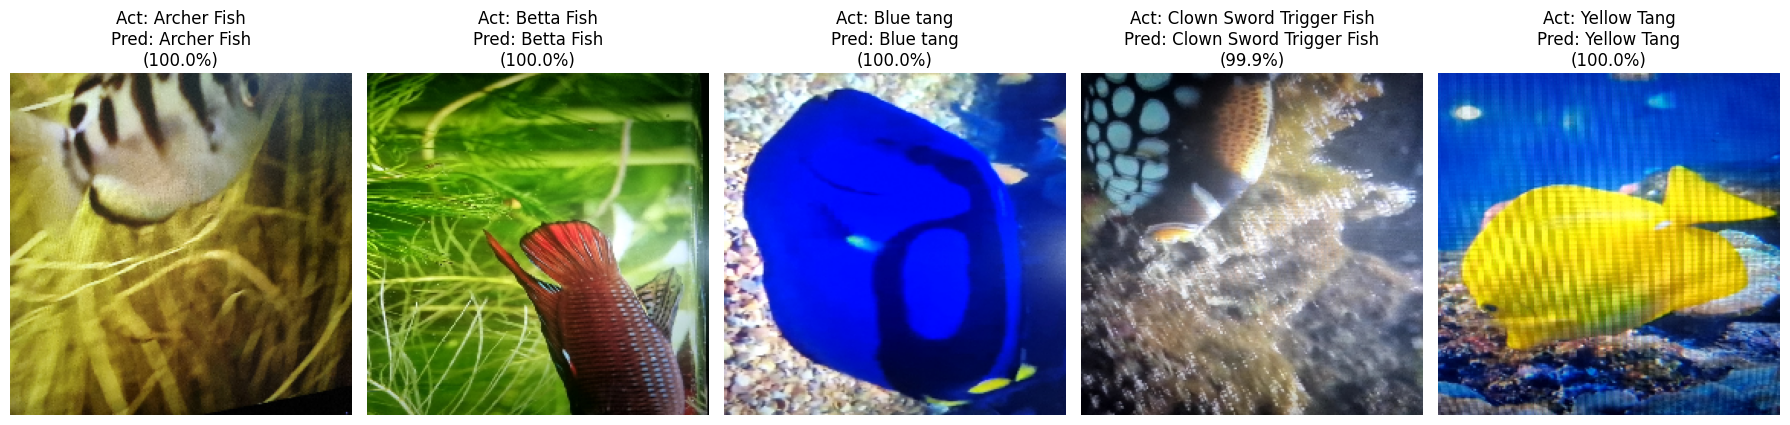

In [ ]:
plt.figure(figsize=(18, 5))
for i, cls in enumerate(class_names):
    cls_path = os.path.join(LOCAL_DATASET_PATH, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)

    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    pred = model.predict(img_array, verbose=0)
    score = tf.nn.softmax(pred[0])
    predicted_cls = class_names[np.argmax(pred)]
    confidence = 100 * np.max(pred)

    plt.subplot(1, num_classes, i + 1)
    plt.imshow(img)
    plt.title(f"Act: {cls}\nPred: {predicted_cls}\n({confidence:.1f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()



---



---



# **Pretrained VGG16 & MobileNetV2**

**Set Path**

In [ ]:
import os

DATASET_PATH = "/content/drive/MyDrive/UAP_klasifikasi_ikan/mydataset"
MODEL_PATH = "/content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained"

os.makedirs(MODEL_PATH, exist_ok=True)

print("Dataset exists:", os.path.exists(DATASET_PATH))
print("Model path:", MODEL_PATH)

Dataset exists: True
Model path: /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained


**IMPORT LIBRARY**

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

**DATA AUGMENTATION**

In [ ]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = len(class_names)

print("Classes:", class_names)


Found 5526 images belonging to 5 classes.
Found 1379 images belonging to 5 classes.
Classes: ['Archer Fish', 'Betta Fish', 'Blue tang', 'Clown Sword Trigger Fish', 'Yellow Tang']


**Class Weight**

In [ ]:
labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.933445945945946), 1: np.float64(1.1524504692387905), 2: np.float64(0.972887323943662), 3: np.float64(1.0647398843930636), 4: np.float64(0.9141439205955335)}


#**MODEL: VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

base_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(160,160,3)
)

base_vgg.trainable = False

x = base_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

vgg_fast = Model(inputs=base_vgg.input, outputs=output)

vgg_fast.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_fast.summary()
()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

()

**CALLBACKS**

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

vgg_ckpt = ModelCheckpoint(
    filepath=f"{MODEL_PATH}/VGG16_fast_best.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

**TRAIN VGG16**

In [ ]:
history_vgg_fast = vgg_fast.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, vgg_ckpt],
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1959 - loss: 1.7743 
Epoch 1: val_loss improved from inf to 1.43589, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 3563s 41s/step - accuracy: 0.1966 - loss: 1.7728 - val_accuracy: 0.5707 - val_loss: 1.4359
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4286 - loss: 1.4126
Epoch 2: val_loss improved from 1.43589 to 1.21960, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.4291 - loss: 1.4119 - val_accuracy: 0.7650 - val_loss: 1.2196
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6230 - loss: 1.1917
Epoch 3: val_loss improved from 1.21960 to 1.03152, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.6234 - loss: 1.1912 - val_accuracy: 0.8006 - val_loss: 1.0315
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7587 - loss: 1.0016
Epoch 4: val_loss improved from 1.03152 to 0.88251, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7587 - loss: 1.0012 - val_accuracy: 0.8281 - val_loss: 0.8825
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7973 - loss: 0.8593
Epoch 5: val_loss improved from 0.88251 to 0.76498, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7974 - loss: 0.8590 - val_accuracy: 0.8426 - val_loss: 0.7650
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8369 - loss: 0.7398
Epoch 6: val_loss improved from 0.76498 to 0.67262, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8370 - loss: 0.7396 - val_accuracy: 0.8550 - val_loss: 0.6726
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8491 - loss: 0.6590
Epoch 7: val_loss improved from 0.67262 to 0.59759, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8492 - loss: 0.6588 - val_accuracy: 0.8637 - val_loss: 0.5976
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8750 - loss: 0.5824
Epoch 8: val_loss improved from 0.59759 to 0.53509, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8750 - loss: 0.5822 - val_accuracy: 0.8738 - val_loss: 0.5351
Epoch 9/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8875 - loss: 0.5164
Epoch 9: val_loss improved from 0.53509 to 0.48559, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8875 - loss: 0.5164 - val_accuracy: 0.8796 - val_loss: 0.4856
Epoch 10/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9001 - loss: 0.4698
Epoch 10: val_loss improved from 0.48559 to 0.44210, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9001 - loss: 0.4697 - val_accuracy: 0.8847 - val_loss: 0.4421
Epoch 11/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9103 - loss: 0.4223
Epoch 11: val_loss improved from 0.44210 to 0.40687, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9102 - loss: 0.4223 - val_accuracy: 0.8963 - val_loss: 0.4069
Epoch 12/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9203 - loss: 0.3857
Epoch 12: val_loss improved from 0.40687 to 0.37630, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9202 - loss: 0.3856 - val_accuracy: 0.9115 - val_loss: 0.3763
Epoch 13/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9107 - loss: 0.3778
Epoch 13: val_loss improved from 0.37630 to 0.35102, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9108 - loss: 0.3776 - val_accuracy: 0.9057 - val_loss: 0.3510
Epoch 14/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9233 - loss: 0.3354
Epoch 14: val_loss improved from 0.35102 to 0.33183, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9233 - loss: 0.3354 - val_accuracy: 0.9123 - val_loss: 0.3318
Epoch 15/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9228 - loss: 0.3187
Epoch 15: val_loss improved from 0.33183 to 0.31139, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9229 - loss: 0.3187 - val_accuracy: 0.9195 - val_loss: 0.3114


**Plot VGG16**

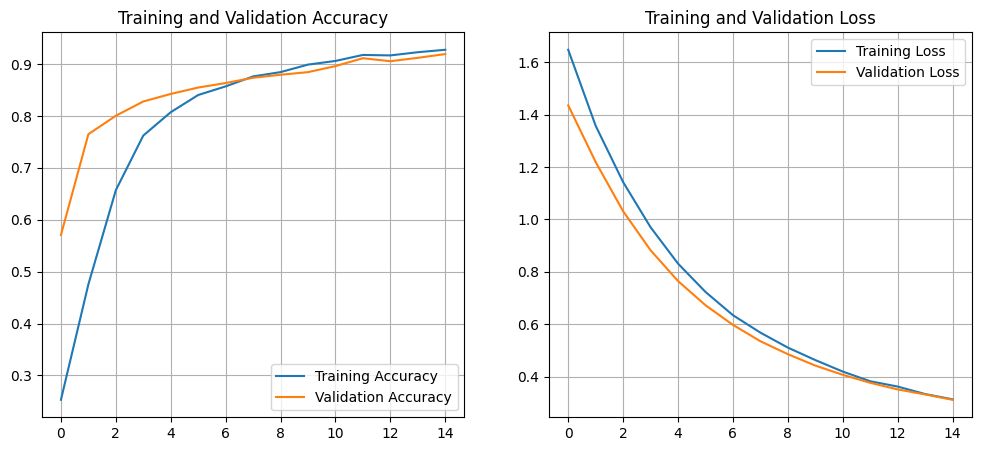

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

# Panggil fungsinya
plot_history(history_vgg_fast)

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

#**MODEL: MOBILENETV2**

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen_mobilenet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=5,        # lebih kecil → lebih cepat
    zoom_range=0.05,
    horizontal_flip=True
)

In [ ]:
train_gen_mobilenet = train_datagen_mobilenet.flow_from_directory(
    DATASET_PATH,
    target_size=(160,160),
    batch_size=64,           # MobileNet aman batch besar
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen_mobilenet = train_datagen_mobilenet.flow_from_directory(
    DATASET_PATH,
    target_size=(160,160),
    batch_size=64,
    class_mode='categorical',
    subset='validation', # Ini yang membedakan isinya dengan train_gen
    shuffle=False
)

Found 5526 images belonging to 5 classes.
Found 1379 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

base_mobilenet = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(160,160,3),
    alpha=0.75          # 🔥 model lebih ringan
)

base_mobilenet.trainable = False

x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)   # 🔥 lebih kecil
x = Dropout(0.3)(x)                       # 🔥 lebih cepat
output = Dense(NUM_CLASSES, activation='softmax')(x)

mobilenet_fast = Model(
    inputs=base_mobilenet.input,
    outputs=output
)
mobilenet_fast.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        648 │ input_layer_1[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │         96 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        216 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         96 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        384 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 1,464,373 (5.59 MB)

 Trainable params: 82,309 (321.52 KB)

 Non-trainable params: 1,382,064 (5.27 MB)

In [ ]:
mobilenet_fast.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # 🔥 lebih cepat converge
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**CALLBACKS MOBILENET**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop_mobilenet = EarlyStopping(
    monitor='val_loss',
    patience=2,                 # 🔥 stop lebih cepat
    restore_best_weights=True
)

mobilenet_ckpt = ModelCheckpoint(
    filepath=f"{MODEL_PATH}/MobileNetV2_fast_best.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

**TRAIN MOBILENETV2**

In [ ]:
history_mobilenet_fast = mobilenet_fast.fit(
    train_gen_mobilenet,
    validation_data=val_gen_mobilenet,
    epochs=10,                   # 🔥 10 epoch cukup
    callbacks=[early_stop_mobilenet, mobilenet_ckpt],
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8119 - loss: 0.5584
Epoch 1: val_loss improved from inf to 0.05449, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/MobileNetV2_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8132 - loss: 0.5546 - val_accuracy: 0.9884 - val_loss: 0.0545
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9901 - loss: 0.0344
Epoch 2: val_loss improved from 0.05449 to 0.04317, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/MobileNetV2_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9901 - loss: 0.0344 - val_accuracy: 0.9898 - val_loss: 0.0432
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9964 - loss: 0.0144
Epoch 3: val_loss improved from 0.04317 to 0.03303, saving model to /content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/MobileNetV2_fast_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9964 - loss: 0.0144 - val_accuracy: 0.9906 - val_loss: 0.0330
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9969 - loss: 0.0107
Epoch 4: val_loss did not improve from 0.03303
87/87 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9969 - loss: 0.0107 - val_accuracy: 0.9884 - val_loss: 0.0390
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9983 - loss: 0.0073
Epoch 5: val_loss did not improve from 0.03303
87/87 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9983 - loss: 0.0073 - val_accuracy: 0.9906 - val_loss: 0.0337


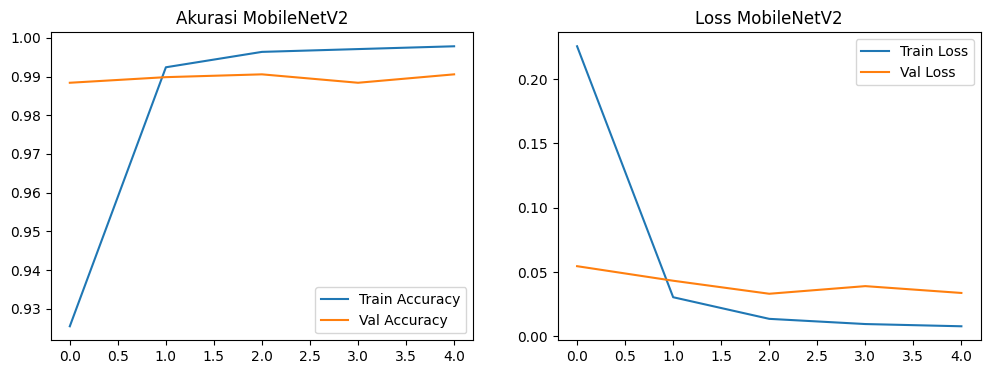

In [ ]:
import matplotlib.pyplot as plt

# Plot Akurasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet_fast.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet_fast.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi MobileNetV2')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet_fast.history['loss'], label='Train Loss')
plt.plot(history_mobilenet_fast.history['val_loss'], label='Val Loss')
plt.title('Loss MobileNetV2')
plt.legend()

plt.show()

# **PREDIKSI & PERBANDINGAN 2 MODEL**

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess

# --- 1. SET PATH SESUAI STRUKTUR DRIVE KAMU ---
BASE_PATH = "/content/drive/MyDrive/UAP_klasifikasi_ikan"
MODEL_DIR = f"{BASE_PATH}/Model_pre-trained"

# Kita arahkan ke 'mydataset'. Jika di dalamnya ada folder 'val', tambahkan /val
# Contoh: f"{BASE_PATH}/mydataset/val"
TEST_DATA_PATH = f"{BASE_PATH}/mydataset"

# --- 2. LOAD MODELS ---
print("⏳ Loading models...")
vgg_m = tf.keras.models.load_model(f"{MODEL_DIR}/VGG16_fast_best.h5")
mobile_m = tf.keras.models.load_model(f"{MODEL_DIR}/MobileNetV2_fast_best.h5")
print("✅ Models loaded successfully!")

# --- 3. FUNGSI PREDIKSI ---
def compare_fish_models(dataset_path, num_per_class=2):
    # Cek folder
    if not os.path.exists(dataset_path):
        print(f"❌ Folder tidak ditemukan: {dataset_path}")
        return

    # Ambil kelas (subfolder)
    class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

    # Jika 'mydataset' isinya langsung kelas, lanjut.
    # Jika isinya 'train'/'val', masuk ke folder 'val' otomatis
    if 'val' in class_names:
        print("📂 Masuk ke folder 'val'...")
        dataset_path = os.path.join(dataset_path, 'val')
        class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_per_class, figsize=(5 * num_per_class, 4 * num_classes))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Ambil sampel acak
        sample_imgs = random.sample(images, min(num_per_class, len(images)))

        for j, img_name in enumerate(sample_imgs):
            img_path = os.path.join(class_dir, img_name)

            # Load & Resize
            img_raw = image.load_img(img_path, target_size=(160, 160))
            img_array = image.img_to_array(img_raw)
            img_batch = np.expand_dims(img_array, axis=0)

            # Prediksi VGG16 (Mean Subtraction)
            p_vgg = vgg_m.predict(vgg_preprocess(img_batch.copy()), verbose=0)
            res_vgg = class_names[np.argmax(p_vgg)]

            # Prediksi MobileNetV2 (Scaling -1 to 1)
            p_mob = mobile_m.predict(mobile_preprocess(img_batch.copy()), verbose=0)
            res_mob = class_names[np.argmax(p_mob)]

            # Plotting
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.imshow(img_raw)

            ax.set_title(f"Target: {class_name}\nVGG: {res_vgg}\nMobile: {res_mob}", fontsize=9)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

⏳ Loading models...


✅ Models loaded successfully!


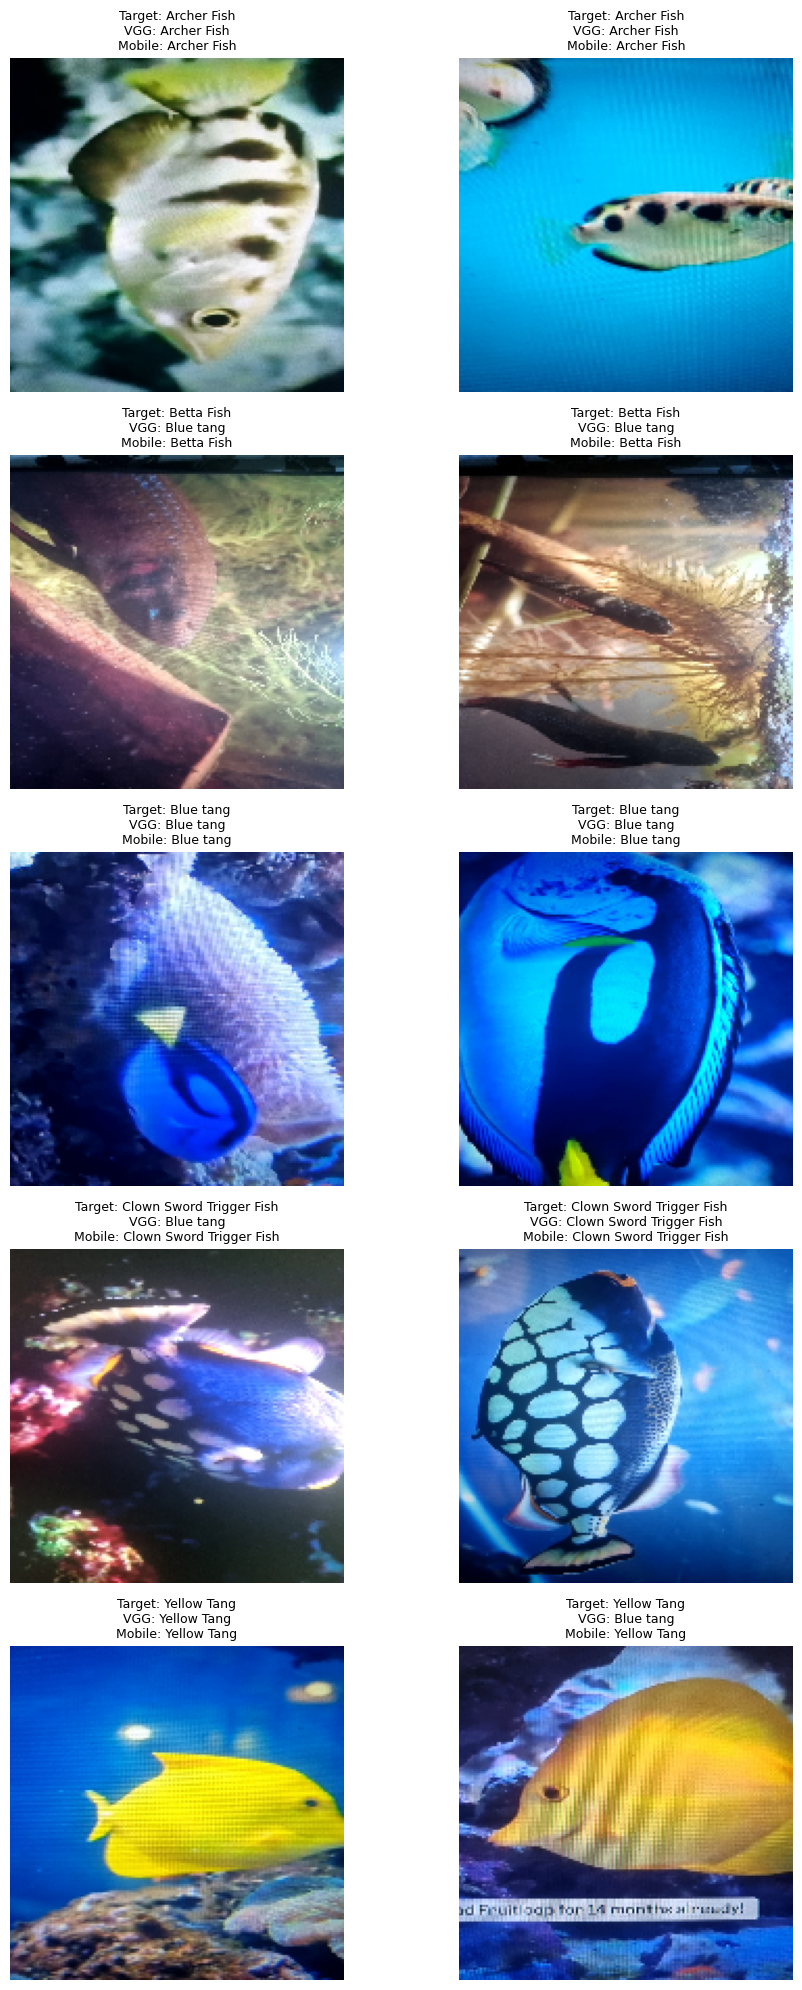

In [ ]:
# Jalankan
compare_fish_models(TEST_DATA_PATH)

In [ ]:
import os
# Ganti ini ke folder utama proyekmu di Drive
proyek_path = "/content/drive/MyDrive/UAP_klasifikasi_ikan/"
print(os.listdir(proyek_path))

['mydataset', 'Model_pre-trained']


In [ ]:
import os

def compare_model_size():
    vgg_size = os.path.getsize(f"{MODEL_DIR}/VGG16_fast_best.h5") / (1024 * 1024)
    mobile_size = os.path.getsize(f"{MODEL_DIR}/MobileNetV2_fast_best.h5") / (1024 * 1024)

    print(f"📊 PERBANDINGAN UKURAN FILE:")
    print(f"------------------------------")
    print(f"📦 VGG16      : {vgg_size:.2f} MB")
    print(f"📦 MobileNetV2: {mobile_size:.2f} MB")
    print(f"------------------------------")
    print(f"🚀 MobileNetV2 sekitar {vgg_size/mobile_size:.1f}x lebih ringan!")

compare_model_size()

📊 PERBANDINGAN UKURAN FILE:
------------------------------
📦 VGG16      : 56.98 MB
📦 MobileNetV2: 6.73 MB
------------------------------
🚀 MobileNetV2 sekitar 8.5x lebih ringan!


# **Evaluasi Hasil MobilNetV2 & VGG16**

⏳ Predicting with VGG16...
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 729ms/step

⏳ Predicting with MobileNetV2...
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 829ms/step


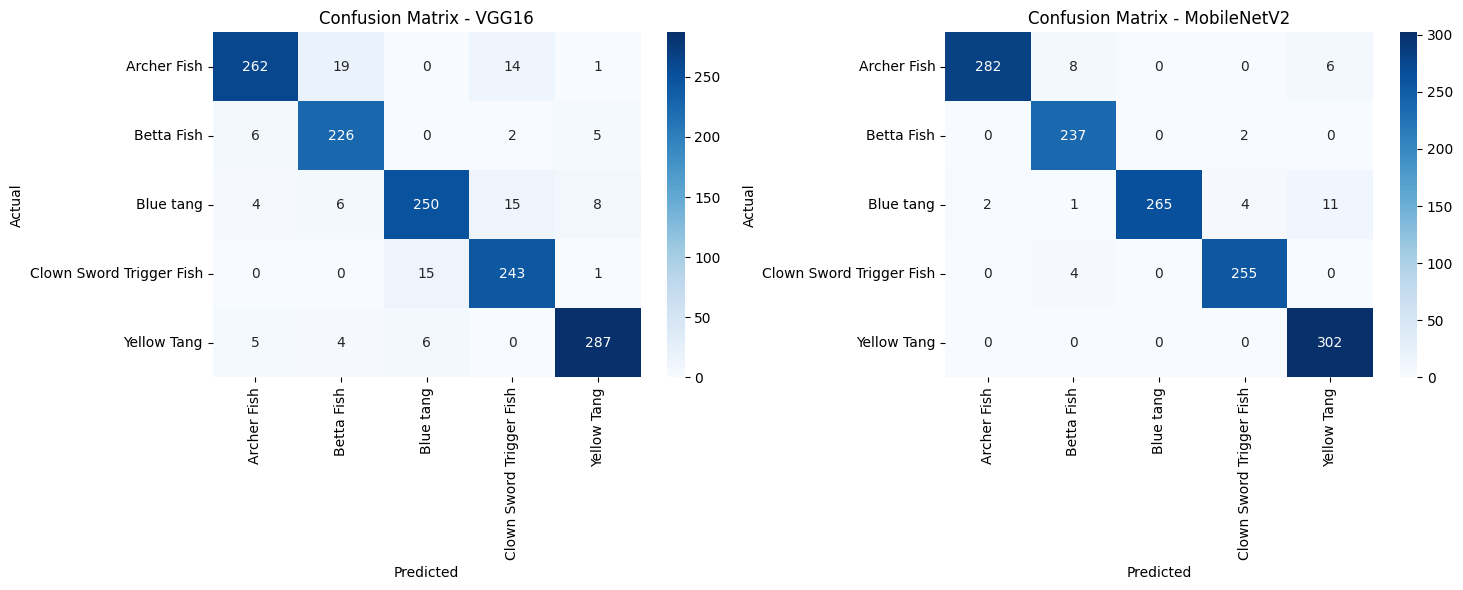


📊 CLASSIFICATION REPORT - VGG16
                          precision    recall  f1-score   support

             Archer Fish       0.95      0.89      0.91       296
              Betta Fish       0.89      0.95      0.91       239
               Blue tang       0.92      0.88      0.90       283
Clown Sword Trigger Fish       0.89      0.94      0.91       259
             Yellow Tang       0.95      0.95      0.95       302

                accuracy                           0.92      1379
               macro avg       0.92      0.92      0.92      1379
            weighted avg       0.92      0.92      0.92      1379


📊 CLASSIFICATION REPORT - MobileNetV2
                          precision    recall  f1-score   support

             Archer Fish       0.99      0.95      0.97       296
              Betta Fish       0.95      0.99      0.97       239
               Blue tang       1.00      0.94      0.97       283
Clown Sword Trigger Fish       0.98      0.98      0.98       259


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Pastikan Ground Truth dan Class Names siap
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# 2. Prediksi VGG16 (Gunakan nama variabel yang sudah di-load: vgg_model)
print("⏳ Predicting with VGG16...")
val_generator.reset()
y_pred_vgg_raw = vgg_model.predict(val_generator, verbose=1)
y_pred_vgg = np.argmax(y_pred_vgg_raw, axis=1)

# 3. Prediksi MobileNetV2 (Gunakan nama variabel yang sudah di-load: mobile_model)
print("\n⏳ Predicting with MobileNetV2...")
val_generator.reset()
y_pred_mobile_raw = mobile_model.predict(val_generator, verbose=1)
y_pred_mobile = np.argmax(y_pred_mobile_raw, axis=1)

# --- VISUALISASI HASIL ---

def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(title)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Tampilkan Confusion Matrix
plot_cm(y_true, y_pred_vgg, 'Confusion Matrix - VGG16', ax1)
plot_cm(y_true, y_pred_mobile, 'Confusion Matrix - MobileNetV2', ax2)
plt.tight_layout()
plt.show()

# Tampilkan Classification Report
print("\n" + "="*50)
print("📊 CLASSIFICATION REPORT - VGG16")
print("="*50)
print(classification_report(y_true, y_pred_vgg, target_names=class_names))

print("\n" + "="*50)
print("📊 CLASSIFICATION REPORT - MobileNetV2")
print("="*50)
print(classification_report(y_true, y_pred_mobile, target_names=class_names))

**PLOT AKURASI & LOSS (PERBANDINGAN)**

/tmp/ipython-input-151970827.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-151970827.py:41: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


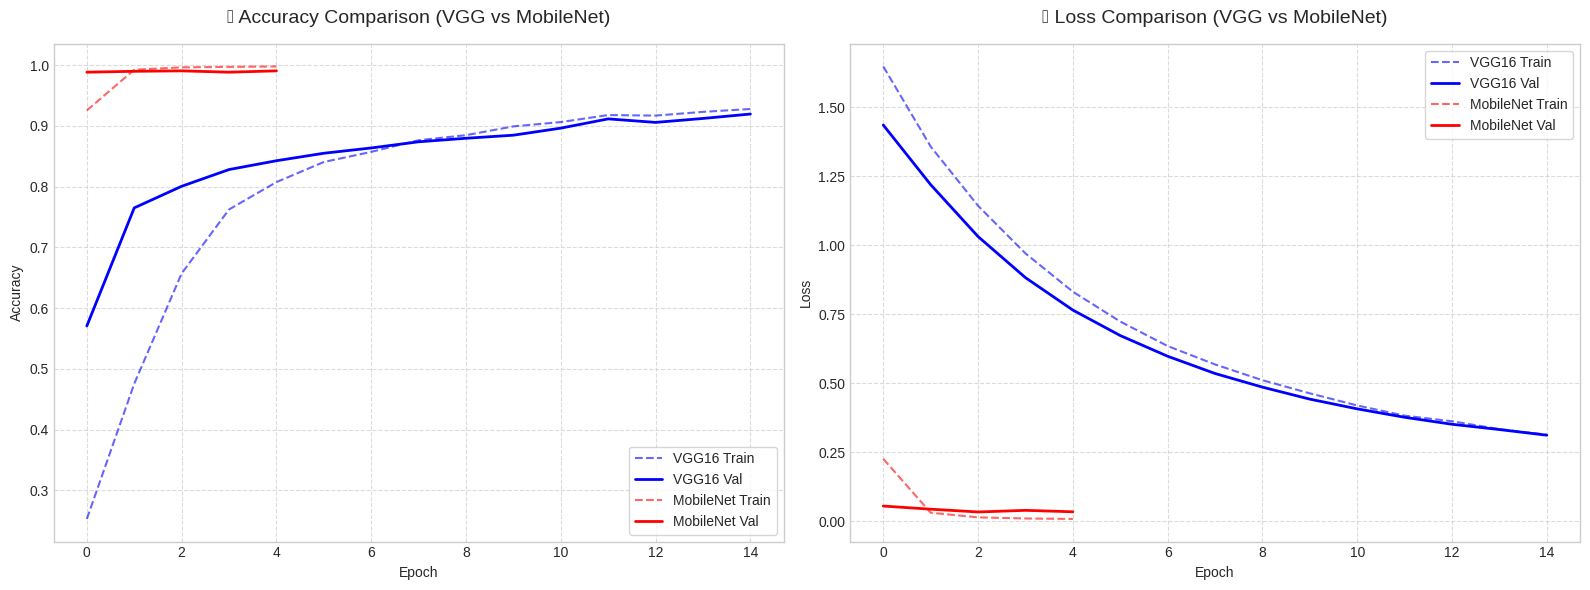

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(hist_vgg, hist_mobilenet):
    # Mengambil data dari history (handle jika objeknya adalah history atau dict)
    vgg_data = hist_vgg.history if hasattr(hist_vgg, 'history') else hist_vgg
    mobile_data = hist_mobilenet.history if hasattr(hist_mobilenet, 'history') else hist_mobilenet

    plt.figure(figsize=(16, 6))
    plt.style.use('seaborn-v0_8-whitegrid') # Style yang lebih bersih

    # --- 1. PLOT ACCURACY ---
    plt.subplot(1, 2, 1)
    # VGG Plot
    plt.plot(vgg_data['accuracy'], 'b--', label='VGG16 Train', alpha=0.6)
    plt.plot(vgg_data['val_accuracy'], 'b-', label='VGG16 Val', linewidth=2)
    # MobileNet Plot
    plt.plot(mobile_data['accuracy'], 'r--', label='MobileNet Train', alpha=0.6)
    plt.plot(mobile_data['val_accuracy'], 'r-', label='MobileNet Val', linewidth=2)

    plt.title("📈 Accuracy Comparison (VGG vs MobileNet)", fontsize=14, pad=15)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(frameon=True)
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- 2. PLOT LOSS ---
    plt.subplot(1, 2, 2)
    # VGG Plot
    plt.plot(vgg_data['loss'], 'b--', label='VGG16 Train', alpha=0.6)
    plt.plot(vgg_data['val_loss'], 'b-', label='VGG16 Val', linewidth=2)
    # MobileNet Plot
    plt.plot(mobile_data['loss'], 'r--', label='MobileNet Train', alpha=0.6)
    plt.plot(mobile_data['val_loss'], 'r-', label='MobileNet Val', linewidth=2)

    plt.title("📉 Loss Comparison (VGG vs MobileNet)", fontsize=14, pad=15)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(frameon=True)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# CARA PAKAI:
# Pastikan variabel history_vgg_fast dan history_mobilenet_fast masih ada di memory
plot_training_history(history_vgg_fast, history_mobilenet_fast)

**SIMPAN MODEL UNTUK STREAMLIT**

In [ ]:
# =========================
# IMPORT
# =========================
import os
import pickle
import tensorflow as tf

# =========================
# PATH GOOGLE DRIVE
# =========================
# Pastikan folder sudah ada
MODEL_PATH = "/content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained"
os.makedirs(MODEL_PATH, exist_ok=True)

# =========================
# LOAD BEST MODEL (DARI CHECKPOINT)
# =========================
# Memuat hasil terbaik yang disimpan oleh ModelCheckpoint selama training
try:
    vgg_best = tf.keras.models.load_model(f"{MODEL_PATH}/VGG16_fast_best.h5")
    mobilenet_best = tf.keras.models.load_model(f"{MODEL_PATH}/MobileNetV2_fast_best.h5")
    print("✅ Model checkpoint berhasil dimuat.")
except Exception as e:
    print(f"⚠️ Gagal memuat model: {e}")

# =========================
# SIMPAN ULANG MODEL (FORMAT .h5)
# =========================
# Disimpan ulang sebagai model final untuk Streamlit
vgg_best.save(f"{MODEL_PATH}/VGG16_best.h5")
mobilenet_best.save(f"{MODEL_PATH}/MobileNetV2_best.h5")

# =========================
# SIMPAN METADATA (UNTUK STREAMLIT)
# =========================
# Metadata sangat penting agar Streamlit tahu urutan label ikan

# 1. Simpan Nama Kelas (List)
with open(f"{MODEL_PATH}/class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)

# 2. Simpan Ukuran Gambar (Agar Streamlit tahu harus resize ke berapa)
with open(f"{MODEL_PATH}/img_size.pkl", "wb") as f:
    pickle.dump(IMG_SIZE, f)

# 3. Simpan Class Indices (Mapping angka ke nama kelas)
# Kita gunakan train_generator karena ini adalah generator utama Anda
with open(f"{MODEL_PATH}/class_indices.pkl", "wb") as f:
    pickle.dump(train_generator.class_indices, f)

# =========================
# SIMPAN HISTORY TRAINING (OPSIONAL)
# =========================
# Berguna jika ingin membuat grafik di Streamlit atau laporan
try:
    with open(f"{MODEL_PATH}/history_vgg.pkl", "wb") as f:
        pickle.dump(history_vgg_fast.history, f)
    with open(f"{MODEL_PATH}/history_mobilenet.pkl", "wb") as f:
        pickle.dump(history_mobilenet_fast.history, f)
    print("✅ History training berhasil disimpan.")
except NameError:
    print("⚠️ History tidak ditemukan, melewati tahap ini.")

# =========================
# VERIFIKASI FILE
# =========================
print("\n📦 FILE SIAP UNTUK STREAMLIT (DI DRIVE):")
files = sorted(os.listdir(MODEL_PATH))
for file in files:
    print(" -", file)

print("\n✅ SEMUA MODEL & METADATA BERHASIL DISIMPAN DENGAN BENAR")

✅ Model checkpoint berhasil dimuat.


✅ History training berhasil disimpan.

📦 FILE SIAP UNTUK STREAMLIT (DI DRIVE):
 - MobileNetV2_best.h5
 - MobileNetV2_fast_best.h5
 - VGG16_best.h5
 - VGG16_fast_best.h5
 - class_indices.pkl
 - class_names.pkl
 - history_mobilenet.pkl
 - history_vgg.pkl
 - img_size.pkl

✅ SEMUA MODEL & METADATA BERHASIL DISIMPAN DENGAN BENAR


In [ ]:
!ls "/content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained"

class_indices.pkl      history_vgg.pkl	    MobileNetV2_fast_best.h5
class_names.pkl        img_size.pkl	    VGG16_best.h5
history_mobilenet.pkl  MobileNetV2_best.h5  VGG16_fast_best.h5


# **DASHBOARD STREAMLIT KLASIFIKASI IKAN**

**Instalasi library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Buat Model VGG

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(
    "/content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best.h5",
    compile=False
)

# Simpan ulang dengan format baru
model.save(
    "/content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/VGG16_fast_best_FIXED.keras",
    save_format="keras"
)

MobilnetV2

In [ ]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/MobileNetV2_fast_best.h5",
    compile=False
)

model.save(
    "/content/drive/MyDrive/UAP_klasifikasi_ikan/Model_pre-trained/MobileNetV2_fast_best_FIXED.keras",
    save_format="keras"
)

In [ ]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 122.3 MB/s eta 0:00:00


**Membuat file app.py**

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle
import json
import pandas as pd
import plotly.express as px
import os

# ======================
# KONFIGURASI PATH & APP
# ======================
BASE_PATH = "/content/drive/MyDrive/UAP_klasifikasi_ikan/"
PATH_MODEL_FINAL = BASE_PATH + "Model_Final/"
PATH_MODEL_PRE = BASE_PATH + "Model_pre-trained/"

CNN_MODEL_FILE = PATH_MODEL_FINAL + "fish_classifier_final.h5"
CNN_LABEL_JSON = PATH_MODEL_FINAL + "fish_labels_final.json"

MODEL_PATHS = {
    "Custom CNN": CNN_MODEL_FILE,
    "VGG16 (Transfer Learning)": PATH_MODEL_PRE + "VGG16_fast_best.h5",
    "MobileNetV2 (Lightweight)": PATH_MODEL_PRE + "MobileNetV2_fast_best.h5",
}

LABEL_PRETRAINED_PATH = PATH_MODEL_PRE + "class_names.pkl"

st.set_page_config(page_title="Fish Classifier Pro", layout="wide", page_icon="🐟")

# ======================
# CUSTOM CSS (KEEP UI)
# ======================
st.markdown("""
    <style>
    .main { background-color: #0e1117; color: white; }
    [data-testid="stMetric"] {
        background-color: #161b22 !important;
        border: 1px solid #30363d;
        padding: 20px !important;
        border-radius: 12px !important;
    }
    [data-testid="stMetricLabel"] { color: #8b949e !important; font-size: 16px !important; }
    [data-testid="stMetricValue"] { color: #58a6ff !important; font-weight: bold !important; }
    section[data-testid="stSidebar"] { background-color: #0d1117; }
    .sidebar-fish-icon { font-size: 100px; text-align: center; margin-bottom: 20px; }
    </style>
    """, unsafe_allow_html=True)

# ======================
# LOAD RESOURCES
# ======================
@st.cache_resource
def load_all_resources():
    models = {}
    labels = {}
    try:
        with open(LABEL_PRETRAINED_PATH, "rb") as f:
            labels["pretrained"] = pickle.load(f)
    except:
        labels["pretrained"] = []

    if os.path.exists(CNN_LABEL_JSON):
        try:
            with open(CNN_LABEL_JSON, "r") as f:
                labels["cnn"] = json.load(f)
        except:
            labels["cnn"] = labels["pretrained"]
    else:
        labels["cnn"] = labels["pretrained"]

    for name, path in MODEL_PATHS.items():
        if os.path.exists(path):
            try:
                models[name] = tf.keras.models.load_model(path, compile=False)
            except Exception as e:
                st.error(f"Gagal memuat {name}: {e}")
    return models, labels

loaded_models, all_labels = load_all_resources()

# ======================
# SIDEBAR
# ======================
with st.sidebar:
    st.markdown('<div class="sidebar-fish-icon">🐟</div>', unsafe_allow_html=True)
    st.title("Control Panel")
    st.divider()
    selected_models = st.multiselect(
        "Pilih model untuk komparasi:",
        options=list(loaded_models.keys()),
        default=list(loaded_models.keys())
    )
    st.divider()
    st.info("Custom CNN disinkronkan dengan Model_Final.")

# ======================
# MAIN CONTENT
# ======================
st.title("🐟 Dashboard Klasifikasi Ikan")
st.markdown("---")

if not selected_models:
    st.warning("👈 Pilih setidaknya satu model di sidebar.")
    st.stop()

uploaded_file = st.file_uploader("Upload gambar ikan (JPG/PNG)", type=["jpg", "jpeg", "png"])

if uploaded_file:
    img = Image.open(uploaded_file).convert("RGB")
    col1, col2 = st.columns([1, 2])

    with col1:
        st.subheader("🖼️ Input Gambar")
        st.image(img, use_container_width=True, caption="Gambar diunggah")

    with col2:
        st.subheader("📊 Analisis Prediksi")
        results = []
        tabs = st.tabs(selected_models)

        for i, model_name in enumerate(selected_models):
            with tabs[i]:
                model = loaded_models[model_name]
                curr_labels = all_labels["cnn"] if model_name == "Custom CNN" else all_labels["pretrained"]

                # --- PERBAIKAN LOGIKA INPUT SIZE ---
                # Mengambil ukuran target (H, W) otomatis dari model
                # model.input_shape biasanya (None, Height, Width, Channels)
                target_h, target_w = model.input_shape[1], model.input_shape[2]

                img_resized = img.resize((target_w, target_h))
                img_array = tf.keras.preprocessing.image.img_to_array(img_resized)

                # Normalisasi: MobileNet & VGG butuh manual scaling (0-1)
                # Custom CNN kita sudah punya layer Rescaling(1./255) di dalamnya, jadi tidak perlu dibagi lagi
                if model_name != "Custom CNN":
                    img_array = img_array / 255.0

                img_array = np.expand_dims(img_array, axis=0)

                # Prediksi
                preds = model.predict(img_array, verbose=0)

                # Cek jika output butuh Softmax
                if np.max(preds) > 1.0 or np.min(preds) < 0:
                    probs = tf.nn.softmax(preds[0]).numpy()
                else:
                    probs = preds[0]

                idx = np.argmax(probs)
                conf = probs[idx]
                label = curr_labels[idx] if idx < len(curr_labels) else f"Index {idx}"

                # UI Metrics (Kotak Hitam Tetap Dipertahankan)
                c1, c2 = st.columns(2)
                c1.metric("Spesies Terdeteksi", label)
                c2.metric("Confidence", f"{conf*100:.2f}%")

                # Plotly Chart
                df_prob = pd.DataFrame({
                    'Spesies': curr_labels[:len(probs)],
                    'Probabilitas': probs
                }).sort_values('Probabilitas', ascending=True).tail(5)

                fig = px.bar(df_prob, x='Probabilitas', y='Spesies', orientation='h',
                             title=f"Top 5 Kemungkinan ({model_name})",
                             color='Probabilitas', color_continuous_scale='Blues')

                fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', font=dict(color="white"))
                st.plotly_chart(fig, use_container_width=True)

                results.append({"Model": model_name, "Prediksi": label, "Confidence": f"{conf*100:.2f}%"})

        st.divider()
        st.subheader("📝 Ringkasan Perbandingan")
        st.table(pd.DataFrame(results))
else:
    st.info("Silakan unggah gambar ikan untuk melihat hasil analisis dari berbagai model.")

Overwriting app.py


**Menjalankan Ngrok dengan Pembersihan Otomatis**

In [ ]:
from pyngrok import ngrok
import os
import time

# 1. Konfigurasi Token
NGROK_TOKEN = "36x4coU1Sq7M1Y8ZJtvL2aO4f2r_6TD9e1fbjZyAizTQWqmVc"
ngrok.set_auth_token(NGROK_TOKEN)


# 2. Jalankan Streamlit di Background
# Menggunakan port 8501
os.system("nohup streamlit run app.py --server.port 8501 >/dev/null 2>&1 &")

# Berikan waktu agar server internal siap
time.sleep(5)

# 3. Buka Tunnel Baru
try:
    # Memastikan koneksi ke port yang sama dengan streamlit
    public_url = ngrok.connect(8501)
    print("-" * 50)
    print(f"🚀 DASHBOARD SIAP DIAKSES!")
    print(f"Klik link ini: {public_url}")
    print("-" * 50)
except Exception as e:
    print(f"Gagal membuka tunnel: {e}")

--------------------------------------------------
🚀 DASHBOARD SIAP DIAKSES!
Klik link ini: NgrokTunnel: "https://ashlea-mammary-dawn.ngrok-free.dev" -> "http://localhost:8501"
--------------------------------------------------


**Mengakhiri sesi**

In [ ]:
# 2. Bersihkan Sesi Lama (Kill streamlit & ngrok agar tidak bentrok)
!pkill streamlit
!pkill ngrok

def close_all_tunnels():
    try:
        tunnels = ngrok.get_tunnels()
        for tunnel in tunnels:
            print(f"Menutup tunnel: {tunnel.public_url}")
            ngrok.disconnect(tunnel.public_url)
        ngrok.kill()
    except:
        pass
    print("Sesi lama dibersihkan.")

close_all_tunnels()

Sesi lama dibersihkan.
